In [1]:
# Standard Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from IPython.display import display, Latex

In [2]:
# Plot settings
plt.rc("axes", labelsize=18)
plt.rc("xtick", labelsize=16, top=True, direction="in")
plt.rc("ytick", labelsize=16, right=True, direction="in")
plt.rc("axes", titlesize=18)
plt.rc("legend", fontsize=16)
plt.rc("figure", figsize=(7, 5), titlesize=18)

In [3]:
# Functions
def delta_n(m, lamb, d):
    return (m * lamb) / (2 * d)

def delta_n_error(m, lamb, d, d_error):
    return np.sqrt(((m * lamb) / (2 * d**2))**2 * d_error**2)

def n_luft(k):
    return 1 + k

def make_ax(data, x, y, xlabel = 'x', ylabel = 'y', title = 'Title', figsize = (10, 10), label = None):
    # Make fig and ax
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plot data
    ax.errorbar(data[x], data[y], yerr = data['delta_n_error'], fmt = "o", 
                label = label, color = 'red', barsabove = True, capsize = 5)

    # Set title and axis labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Return fig and ax
    return fig, ax

def plot_ax(ax, legend = False, grid = False, save = False, filename = 'default.pdf'):
    if grid:
        ax.grid()
    if legend:
        ax.legend()
    if save:
        plt.savefig(filename)
    plt.show()
    
def calculate_fit_for_k(data):
    _delta_n = lambda x, k: k * x # Alternative version of delta_n function above
    
    # Calculate k
    popt, pcov = curve_fit(_delta_n, data['pressure'], data['delta_n'], p0 = 0.00025, 
                           sigma = data['delta_n_error'], absolute_sigma = True)
    
    # Return k and covariance matrix
    return popt, pcov

def plot_fit_for_k(data, k, ax):
    _delta_n = lambda delta_p, k: k * delta_p # Alternative version of delta_n function above
    
    # Calculate delta_n from fitted parameter k
    delta_n_fit = [_delta_n(d_p, k) for d_p in data['pressure']]
    
    # Plot fit
    ax.plot(data['pressure'], delta_n_fit, color = 'black', linestyle = 'dashed', label = 'Linear fit')
    
    # Return ax
    return ax

def calculate_ks(data):
    return data['delta_n'] / data['pressure']

def calculate_ks_errors(data, delta_p_error):
    return np.sqrt((1 / data['pressure'])**2 * data['delta_n_error']**2 + (data['delta_n'] / data['pressure']**2)**2 * delta_p_error**2)

def calculate_error_for_mean_k(data):
    return np.sqrt(np.sum([error**2 for error in data['k_error']])) / len(data['k_error'])

# Function to get mean
def calc_mean(x):
    if x[0] == 0.7:
        return (x[1] + x[3]) / 2
    elif x[0] == 0.9:
        return (x[1] + x[2]) / 2
    else:
        return (x[1] + x[2] + x[3]) / 3

In [4]:
# Load number of peaks found in cleaning directory
df_initial = pd.read_csv('../Cleaned_Data/Final_data/number_of_peaks.csv')
df_1 = df_initial[df_initial['num'] == 1].reset_index(drop = True)
df_2 = df_initial[df_initial['num'] == 2].reset_index(drop = True)
df_3 = df_initial[df_initial['num'] == 3].reset_index(drop = True)

# Take the mean of the total number of peaks for each of the three data frames
df = pd.DataFrame({'pressure': [], 'total_1': [], 'total_2': [], 'total_3': [], 'total': []})
df['pressure'] = df_1['pressure']
df['total_1'] = df_1['total']
df['total_2'] = df_2['total']
df['total_3'] = df_3['total']
df['total'] = df.apply(calc_mean, axis = 1)

In [5]:
# Visualize dataframe
df.head(6)

,pressure,total_1,total_2,total_3,total
0,0.5,19,19,19,19.000000
1,0.6,21,21,25,22.333333
2,0.7,27,0,29,28.000000
3,0.8,35,33,33,33.666667
4,0.9,39,41,0,40.000000
5,1.0,48,45,45,46.000000


In [6]:
# Variables
lamb = 633 * 10**(-9) #m
d = 6.7 * 10**(-2) #m plus minus 0.005m
d_error = 0.005 #m
delta_p_error = 0.05 #bar
bar_to_atm_factor = 0.986923267

In [7]:
# Calculate a value delta_n for every m (total) - and its corresponding error
df['delta_n'] = [delta_n(m, lamb, d) for m in df['total']]
df['delta_n_error'] = [delta_n_error(m, lamb, d, d_error) for m in df['total']]

# Error in pressure measured on pump is assumed to be 0.05 bar
df['pressure_error'] = [0.05 for m in df['total']]

# Convert pressure from bar to atm
df['pressure'] = df['pressure'] * bar_to_atm_factor

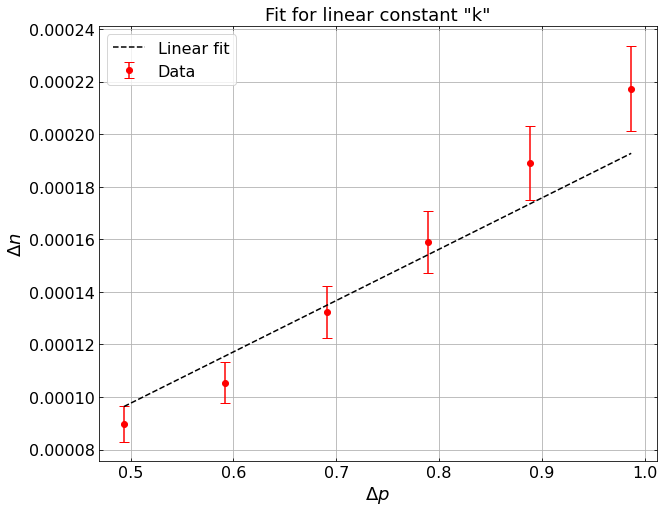

In [8]:
# Plot 'delta_n = k * delta_p' and fit for k (linear)

# Make ax and fig
fig, ax = make_ax(df, x = 'pressure', y = 'delta_n', xlabel = r'$\Delta p$', ylabel = r'$\Delta n$', 
                  title = 'Fit for linear constant "k"', figsize = (10, 8), label = 'Data')

# Make curvefit for k
popt, pcov = calculate_fit_for_k(df)

# Error on k
k_error = np.sqrt(np.diag(pcov))[0]

# Plot fit
ax = plot_fit_for_k(df, popt[0], ax)

# Plot ax
plot_ax(ax, grid = True, legend = True, save = True, filename = 'fit_for_linear_constant_k.pdf')

In [9]:
# Calculate refrative index of air
n_luft_value = n_luft(popt[0])
n_luft_error = k_error # Using errorpropagation for a multivariable function, it can be shown that 'n_luft_error = k_error'

# Print result
display(Latex(f'Refrative index of air equals: {round(n_luft_value, 6)} $\pm$ {round(n_luft_error, 6)}'))

<IPython.core.display.Latex object>

Possible reasons why value is not '1.00025':
  -  Number of maximums and minimums is counted wrongly
  -  Some of the math might be off
  -  Systematic errors in experiment
  
What needs to be done:
  -  Calculate uncertainty in refrative index of air (Done)
  -  Possibly resolve some of the points above
  
Possible solutions:
  -  Make $\Delta$p a function of $\Delta$n and fit for $\frac{1}{k}$, such that the (dominant) errors in $\Delta$p is propagated through curve_fit, instead of the (less dominant) errors in $\Delta$n. This might give a more reasonable estimate of the error on the refractive index of air.

In [10]:
# Possible resolution to the above problem:

# Calculate k for every set of delta_n and delta_p, propagate the error as well, 
# and then take the mean of the results, and propagate the resulting error.

# Calculate ks
df['k'] = calculate_ks(df)

# Calculate errors for ks
df['k_error'] = calculate_ks_errors(df, delta_p_error)

# Mean the values for k
k_mean = np.mean(df['k'])

# Calculate error for mean k
k_mean_error = calculate_error_for_mean_k(df)

# Calculate refrative index of air for this second method (therefore the '_2')
n_luft_value_2 = n_luft(k_mean)
n_luft_error_2 = k_mean_error

# Print result
display(Latex(f'Refrative index of air equals: {round(n_luft_value_2, 6)} $\pm$ {round(n_luft_error_2, 6)}'))

<IPython.core.display.Latex object>